In [42]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import numpy as np
from matplotlib import cm, colors 
import matplotlib.pyplot as plt

import os
from omegaconf import OmegaConf

from linear_case import build_OnsagerNetHD2,generate_coefficients
path = "outputs/reculinear20_HD2_lambda1"
config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
model_template = build_OnsagerNetHD2(config)
net = eqx.tree_deserialise_leaves(path + '/model.eqx', model_template) 

M, J, S = generate_coefficients(config.dim, jr.PRNGKey(config.data.seed))
from linear_case import build_targets
target_SDE = build_targets(M, J*config.data.var, S)
# 绘图部分 
Ng=100
x = np.linspace(-2,2, Ng)
y = np.linspace(-2, 2, Ng)
X, Y = np.meshgrid(x, y)
XY = np.stack([X, Y], axis=-1).reshape(-1, config.dim)

learnedV = jax.vmap(net.potential, in_axes=(0, None))(XY, [config.temperature]).reshape(100, 100)
exactV = jax.vmap(target_SDE.potential, in_axes=(0, None))(XY, [config.temperature]).reshape(100, 100)

[CudaDevice(id=0)]


2025-09-18 11:39:45.158636: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.7 which is older than the PTX compiler version (12.8.61). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(10000, 2)


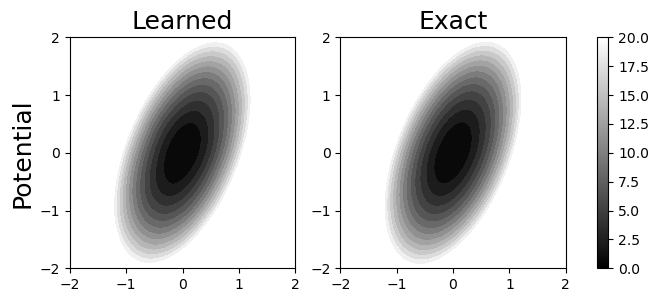

In [48]:

print(XY.shape)
max_v = 20
norm2 = colors.Normalize(vmin=0, vmax=max_v)
# norm2 = colors.PowerNorm(gamma=0.5, vmin=0, vmax=max_v)
# cmap = plt.get_cmap('gist_gray')  # 'viridis', 'plasma', 'inferno', 'magma'
# # plasma, inferno, magma
# cmap="icefire"#coolwarm
cmap="gist_gray"
fig, axf = plt.subplots(1, 2, figsize=(8, 3)) 
c2 = axf[0].contourf(X, Y, learnedV - learnedV.min(), levels=100, cmap=cmap, norm=norm2)
# for c in c2.collections:
#     c.set_rasterized(True)
c2 = axf[1].contourf(X, Y, exactV - exactV.min(), levels=100, cmap=cmap, norm=norm2)
# for c in c2.collections:
#     c.set_rasterized(True)

axf[0].set_title(r'Learned', fontsize=18)
axf[1].set_title(r'Exact', fontsize=18)

axf[0].set_ylabel('Potential', fontsize=18)

for ax in axf:
    ax.set_yticks(np.linspace(-2, 2, 5))
    ax.set_xticks(np.linspace(-2, 2, 5)) 

# cb=fig.colorbar(c2, ax=[axf[0],axf[1]], norm=norm2)
mappable = cm.ScalarMappable(norm=norm2, cmap=cmap)
mappable.set_array([])  
cbar = fig.colorbar(mappable, ax=[axf[0],axf[1]])
plt.savefig('linear_potential.png', dpi=300, bbox_inches='tight')

In [45]:
def gamma_net(net, temperature=0.1):
    def gamma(x):
        args=[temperature]  
        dvdx = jax.grad(net.potential, argnums=0)(x, args)

        #compution of the gamma term
        H = net.Hamiltonian(x)
        grad_H = jax.jacfwd(net.Hamiltonian, argnums=0)(x)
        gamma_value = temperature * jnp.einsum('dab,db->a', net.J, grad_H) - jnp.einsum('d,dab,b->a', H, net.J, dvdx)
        return gamma_value
    return gamma
gamma = gamma_net(net, temperature=0.1)

def gamma_sde(net, temperature=0.1):
    def gamma(x):
        args=[temperature]  
        dvdx = jax.grad(net.potential, argnums=0)(x, args)

        return -(net.conservation(x)) @ dvdx
    return gamma
gamma = gamma_net(net, temperature=1)
gamma_sde = gamma_sde(target_SDE, temperature=1)
learnedf = jax.vmap(gamma, in_axes=(0))(XY)
exactf = jax.vmap(gamma_sde, in_axes=(0))(XY)

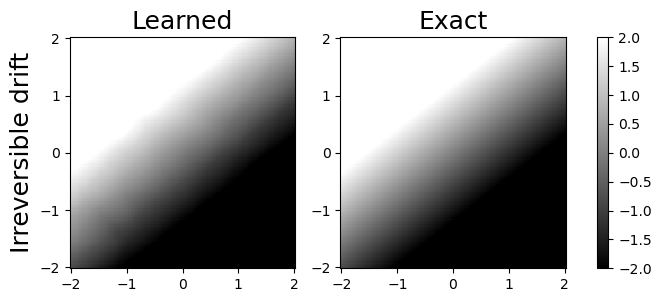

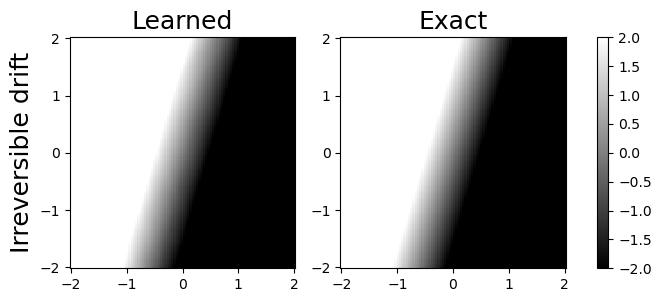

In [47]:


norm1 = colors.Normalize(vmin=-2, vmax=2) 
fig, axf = plt.subplots(1, 2, figsize=(8, 3)) 
c2 = axf[0].pcolormesh(X, Y, learnedf[:,0].reshape(100, 100), cmap=cmap, norm=norm1, rasterized=True)
c2 = axf[1].pcolormesh(X, Y, exactf[:,0].reshape(100, 100), cmap=cmap, norm=norm1, rasterized=True)
axf[0].set_title('Learned', fontsize=18)
axf[1].set_title('Exact', fontsize=18)
axf[0].set_ylabel("Irreversible drift", fontsize=18)
for ax in axf:
    ax.set_yticks(np.linspace(-2, 2, 5))
    ax.set_xticks(np.linspace(-2, 2, 5)) 

# cb=fig.colorbar(c2, ax=[axf[0],axf[1]], norm=norm2)
mappable = cm.ScalarMappable(norm=norm1, cmap=cmap)
mappable.set_array([])  
cbar = fig.colorbar(mappable, ax=[axf[0],axf[1]])
plt.savefig('linear_drift1.svg', dpi=30, bbox_inches='tight')

fig, axf = plt.subplots(1, 2, figsize=(8, 3)) 
c2 = axf[0].pcolormesh(X, Y, learnedf[:,1].reshape(100, 100), cmap=cmap, norm=norm1, rasterized=True)
c2 = axf[1].pcolormesh(X, Y, exactf[:,1].reshape(100, 100), cmap=cmap, norm=norm1, rasterized=True)
axf[0].set_title('Learned', fontsize=18)
axf[1].set_title('Exact', fontsize=18)
axf[0].set_ylabel("Irreversible drift", fontsize=18)
for ax in axf:
    ax.set_yticks(np.linspace(-2, 2, 5))
    ax.set_xticks(np.linspace(-2, 2, 5)) 

# cb=fig.colorbar(c2, ax=[axf[0],axf[1]], norm=norm2)
mappable = cm.ScalarMappable(norm=norm1, cmap=cmap)
mappable.set_array([])  
cbar = fig.colorbar(mappable, ax=[axf[0],axf[1]])
plt.savefig('linear_drift2.svg', dpi=30, bbox_inches='tight')


In [39]:
import sys
sys.path.append('..')
from utils.sde import SDEIntegrator
def entropy_production_linear(net, temperature=0.1):
    z1_min, z1_max = -2, 2
    z2_min, z2_max = -2, 2
    init_unit = jr.uniform(
        key=jr.PRNGKey(123), shape=(1000,2)
    )
    bounds = jnp.array([[z1_min, z1_max],[z2_min, z2_max]])
    init_conditions = bounds[:, 0] + (bounds[:, 1] - bounds[:, 0]) * init_unit 

    integrator = SDEIntegrator(model=net, state_dim=2)
    key = jr.PRNGKey(0) 
    bm_keys = jr.split(key, 1000) 
    sol = integrator.parallel_solve(
        key=bm_keys,
        initial_conditions=init_conditions,
        t0=0.0,
        t1=10,
        dt=0.005,
        args=[temperature],
    )
    predicted_trajectories = sol.ys

    def gamma_net(net, temperature=temperature):
        def gamma(x):
            args=[temperature]  
            dvdx = jax.grad(net.potential, argnums=0)(x, args)

            #compution of the gamma term
            H = net.Hamiltonian(x)
            grad_H = jax.jacfwd(net.Hamiltonian, argnums=0)(x)
            gamma_value = temperature * jnp.einsum('dab,db->a', net.J, grad_H) - jnp.einsum('d,dab,b->a', H, net.J, dvdx)
            return gamma_value
        return gamma

    def ep_term(gamma, dissipation):
        def ep_term_x(x):
            return gamma(x)@(jnp.linalg.inv(dissipation(x))@gamma(x))
        return ep_term_x
    ep_term = ep_term(gamma_net(net), net.dissipation)
    x= predicted_trajectories[:,-100:,].reshape(-1,2)
    ep = jax.vmap(ep_term)(x)
    
    return ep.mean(), predicted_trajectories


def entropy_production_linearsde(sde, temperature=0.1):
    z1_min, z1_max = -2, 2
    z2_min, z2_max = -2, 2
    init_unit = jr.uniform(
        key=jr.PRNGKey(123), shape=(1000,2)
    )
    bounds = jnp.array([[z1_min, z1_max],[z2_min, z2_max]])
    init_conditions = bounds[:, 0] + (bounds[:, 1] - bounds[:, 0]) * init_unit 

    integrator = SDEIntegrator(model=sde, state_dim=2)
    key = jr.PRNGKey(0) 
    bm_keys = jr.split(key, 1000) 
    sol = integrator.parallel_solve(
        key=bm_keys,
        initial_conditions=init_conditions,
        t0=0.0,
        t1=10,
        dt=0.005,
        args=[temperature],
    )
    predicted_trajectories = sol.ys

    def gamma_net(sde, temperature=temperature):
        def gamma(x):
            args=[temperature]  
            dvdx = jax.grad(net.potential, argnums=0)(x, args)
            return -sde.conservation(x) @ dvdx
        return gamma

    def ep_term(gamma, dissipation):
        def ep_term_x(x):
            return gamma(x)@(jnp.linalg.inv(dissipation(x))@gamma(x))
        return ep_term_x

    ep_term = ep_term(gamma_net(sde), sde.dissipation)
    x= predicted_trajectories[:,-100:,].reshape(-1,2)
    ep = jax.vmap(ep_term)(x)
    
    return ep.mean(), predicted_trajectories


ep_list=[]
for lam in [1,0.5,0.25,0.125, 0]:
    path = "outputs/reculinear20_HD2_lambda{}".format(lam)  
    config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
    model_template = build_OnsagerNetHD2(config)
    net = eqx.tree_deserialise_leaves(path + '/model.eqx', model_template) 
    ep_learned, traj = entropy_production_linear(net, temperature=1)

    M, J, S = generate_coefficients(config.dim, jr.PRNGKey(config.data.seed))
    J=J*config.data.var
    target_SDE = build_targets(M, J, S)
    ep_estimated, _ = entropy_production_linearsde(target_SDE, temperature=1)

    M_inv = jnp.linalg.inv(M)

    A = -M_inv@(J@S)@J
    ep_exact = (A[0,0]+A[1,1])
    ep_list.append([lam, ep_learned, ep_estimated, ep_exact])



In [40]:
print(np.array(ep_list))

[[1.00000000e+00 4.88827191e+01 4.97965477e+01 4.70598338e+01]
 [5.00000000e-01 1.19134022e+01 1.28596621e+01 1.17649584e+01]
 [2.50000000e-01 3.02703519e+00 3.16319400e+00 2.94123961e+00]
 [1.25000000e-01 7.45720912e-01 9.06957157e-01 7.35309903e-01]
 [0.00000000e+00 8.59854913e-03 0.00000000e+00 0.00000000e+00]]


In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def discretize_trajectory(trajectory, bin_edges):
    """
    Discretize continuous trajectory into a multidimensional grid
    
    Parameters:
        trajectory: (N, dim) array, dim-dimensional trajectory
        bin_edges: list of bin boundaries for each dimension
        
    Returns:
        bin_indices: (N, dim) array, indices of each point in the multidimensional grid
    """
    dim = trajectory.shape[1]
    n_bins = [len(edges) - 1 for edges in bin_edges]
    bin_indices = np.zeros_like(trajectory, dtype=int)
    
    for d in range(dim):
        # Assign points to bins
        bin_indices[:, d] = np.digitize(trajectory[:, d], bin_edges[d]) - 1
        # Ensure indices are within [0, n_bins[d]-1]
        bin_indices[:, d] = np.clip(bin_indices[:, d], 0, n_bins[d] - 1)
    
    return bin_indices

def determine_global_bins(trajectories, n_bins=10):
    """
    Determine global bin boundaries based on all trajectories
    
    Parameters:
        trajectories: list of trajectories, each is a (N_i, dim) array
        n_bins: number of bins for each dimension
        
    Returns:
        global_bin_edges: list of global bin boundaries
    """
    
    # Collect all trajectory points
    all_points = np.vstack(trajectories)
    dim = all_points.shape[1]
    
    min_vals = np.min(all_points, axis=0)
    max_vals = np.max(all_points, axis=0)
    
    bin_edges = []
    for d in range(dim):
        # Create bin boundaries, slightly expand range to avoid boundary issues
        range_expansion = 0.05 * (max_vals[d] - min_vals[d])
        min_val = min_vals[d] - range_expansion
        max_val = max_vals[d] + range_expansion
        
        edges = np.linspace(min_val, max_val, n_bins + 1)
        bin_edges.append(edges)
    
    return bin_edges

def count_transitions(trajectories, bin_edges):
    """
    Count transitions for all trajectories
    
    Parameters:
        trajectories: list of trajectories
        bin_edges: global bin boundaries
        
    Returns:
        forward_counts_dict: forward transition counts dictionary {(start_index_tuple): {end_index_tuple: count}}
        reverse_counts_dict: reverse transition counts dictionary {(start_index_tuple): {end_index_tuple: count}}
        total_transitions: total number of transitions
    """
    dim = len(bin_edges)
    forward_counts = {}
    reverse_counts = {}
    total_transitions = 0
    
    # Iterate through all trajectories
    for traj_idx, trajectory in enumerate(tqdm(trajectories, desc="Processing trajectories")):
        # Discretize current trajectory
        bin_indices = discretize_trajectory(trajectory, bin_edges)
        n_points = bin_indices.shape[0]
        
        # Count transitions for current trajectory
        for k in range(n_points - 1):
            # Get index tuples for current and next states
            start_idx = tuple(bin_indices[k])
            end_idx = tuple(bin_indices[k+1])
            
            # Forward transition counts
            if start_idx not in forward_counts:
                forward_counts[start_idx] = {}
            if end_idx not in forward_counts[start_idx]:
                forward_counts[start_idx][end_idx] = 0
            forward_counts[start_idx][end_idx] += 1
            
            # Reverse transition counts (time reversal)
            if end_idx not in reverse_counts:
                reverse_counts[end_idx] = {}
            if start_idx not in reverse_counts[end_idx]:
                reverse_counts[end_idx][start_idx] = 0
            reverse_counts[end_idx][start_idx] += 1
            
            total_transitions += 1
    
    return forward_counts, reverse_counts, total_transitions

def calculate_transition_probabilities(counts_dict):
    """
    Calculate transition probabilities
    
    Parameters:
        counts_dict: transition counts dictionary
        
    Returns:
        probs_dict: transition probabilities dictionary {(start_idx): {end_idx: probability}}
    """
    probs_dict = {}
    
    for start_idx, end_counts in counts_dict.items():
        total = sum(end_counts.values())
        probs_dict[start_idx] = {}
        
        for end_idx, count in end_counts.items():
            probs_dict[start_idx][end_idx] = count / total
    
    return probs_dict

def estimate_epr_with_counting(trajectories, dt, n_bins=8, max_irreversible=10.0):
    """
    Estimate entropy production rate using histogram counting method (general dimension version)
    
    Parameters:
        trajectories: list of trajectories, each is a (N_i, dim) array
        dt: time step
        n_bins: number of bins for each dimension
        max_irreversible: maximum KL contribution for completely irreversible transitions
        
    Returns:
        ep_rate: estimated entropy production rate
        kl_contributions: list of KL contributions for all transitions (for diagnostics)
    """
    # 0. Get system dimension
    dim = trajectories[0].shape[1]
    print(f"System dimension: {dim}D, using {n_bins} bins per dimension")
    
    # 1. Determine global bin boundaries
    bin_edges = determine_global_bins(trajectories, n_bins)
    print(f"Bin boundaries determined") 
    
    # 2. Count transitions for all trajectories
    forward_counts, reverse_counts, total_transitions = count_transitions(trajectories, bin_edges)
    print(f"Total transitions: {total_transitions}")
    print(total_transitions)
    
    # 3. Calculate forward transition probabilities
    forward_probs = calculate_transition_probabilities(forward_counts)

    # 4. Calculate reverse transition probabilities
    reverse_probs = calculate_transition_probabilities(reverse_counts)
    
    # 5. Calculate relative entropy contribution for each transition
    kl_contributions = []
    valid_transitions = 0
    irreversible_transitions = 0
    
    # Get minimum reverse probability
    min_val = min(
        prob
        for inner in reverse_probs.values()
        for prob in inner.values()
        if prob > 0
    )
    print('min', min_val)
    for start_idx, end_dict in tqdm(forward_counts.items(), desc="Calculating KL divergence"):
        for end_idx, count in end_dict.items():
            # Get forward probability
            p_forward = forward_probs[start_idx][end_idx]
            
            # Get reverse probability - note direction reversal
            p_reverse = 0.0 
            if end_idx in reverse_probs.get(start_idx, {}):
                p_reverse = reverse_probs[start_idx][end_idx] 
            
            # Calculate KL contribution
            if p_reverse > 0:
                log_ratio = np.log(p_forward / p_reverse)
            else:
                # Completely irreversible transition
                log_ratio = np.log(p_forward /min_val* max_irreversible)
                irreversible_transitions += count
            
            # Accumulate contributions for each occurrence of this transition
            kl_contributions.extend([log_ratio] * count)
            valid_transitions += count
    
    # 6. Calculate average relative entropy
    if valid_transitions > 0:
        H = np.mean(kl_contributions)
    else:
        H = 0.0
        print("Warning: No valid transitions found!")
    
    # 7. Calculate entropy production rate
    ep_rate = H / dt
    
    print(f"Valid transitions: {valid_transitions}/{total_transitions} ({100*valid_transitions/total_transitions:.1f}%)")
    print(f"Completely irreversible transitions: {irreversible_transitions} ({100*irreversible_transitions/total_transitions:.1f}%)")
    print(f"Average relative entropy H: {H:.6f}")
    print(f"Estimated entropy production rate: {ep_rate:.4f}")
    
    return ep_rate, kl_contributions

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import numpy as np
from matplotlib import cm, colors 
import matplotlib.pyplot as plt

import os
from omegaconf import OmegaConf

from linear_case import load_data

for lam in [1,0.5,0.25,0.125, 0]:
    path = "outputs/reculinear20_HD2_lambda{}".format(lam) 
    config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
    config.data.t1=10
    config.data.num_runs_test=100000 
    train_dataset, test_dataset = load_data(config)
    ep_rate, kl_contributions = estimate_epr_with_counting(
        trajectories=test_dataset['x'][:,-500:,],
        dt=config.dt,
        n_bins=100
    )


[[ 0.02595867 -0.01463836]
 [-0.01463836  0.02783796]] 
 [[ 0.         -0.12367745]
 [ 0.12367745  0.        ]] 
 [[ 33.97958886 -10.35827272]
 [-10.35827272  13.60290032]]
系统维度: 2D, 每个维度使用 100 bins
Bin边界已确定


处理轨迹: 100%|██████████| 100000/100000 [04:02<00:00, 412.87it/s]


总转移次数: 49900000
49900000
min 8.790049663780601e-06


计算KL散度: 100%|██████████| 5318/5318 [00:00<00:00, 10102.43it/s]


有效转移: 49900000/49900000 (100.0%)
完全不可逆转移: 239751 (0.5%)
平均相对熵 H: 0.339583
估计的熵产生率: 33.9583
[[ 0.02595867 -0.01463836]
 [-0.01463836  0.02783796]] 
 [[ 0.         -0.12367745]
 [ 0.12367745  0.        ]] 
 [[ 33.97958886 -10.35827272]
 [-10.35827272  13.60290032]]
系统维度: 2D, 每个维度使用 100 bins
Bin边界已确定


处理轨迹: 100%|██████████| 100000/100000 [03:57<00:00, 420.72it/s]


总转移次数: 49900000
49900000
min 8.553295584788819e-06


计算KL散度: 100%|██████████| 5059/5059 [00:00<00:00, 8184.80it/s]


有效转移: 49900000/49900000 (100.0%)
完全不可逆转移: 51536 (0.1%)
平均相对熵 H: 0.085129
估计的熵产生率: 8.5129
[[ 0.02595867 -0.01463836]
 [-0.01463836  0.02783796]] 
 [[ 0.         -0.12367745]
 [ 0.12367745  0.        ]] 
 [[ 33.97958886 -10.35827272]
 [-10.35827272  13.60290032]]
系统维度: 2D, 每个维度使用 100 bins
Bin边界已确定


处理轨迹: 100%|██████████| 100000/100000 [04:39<00:00, 358.13it/s]


总转移次数: 49900000
49900000
min 6.049350602212853e-06


计算KL散度: 100%|██████████| 4205/4205 [00:00<00:00, 5661.03it/s]


有效转移: 49900000/49900000 (100.0%)
完全不可逆转移: 15884 (0.0%)
平均相对熵 H: 0.021483
估计的熵产生率: 2.1483
[[ 0.02595867 -0.01463836]
 [-0.01463836  0.02783796]] 
 [[ 0.         -0.12367745]
 [ 0.12367745  0.        ]] 
 [[ 33.97958886 -10.35827272]
 [-10.35827272  13.60290032]]
系统维度: 2D, 每个维度使用 100 bins
Bin边界已确定


处理轨迹: 100%|██████████| 100000/100000 [04:15<00:00, 391.23it/s]


总转移次数: 49900000
49900000
min 3.7099281386919535e-06


计算KL散度: 100%|██████████| 2713/2713 [00:00<00:00, 4412.66it/s]


有效转移: 49900000/49900000 (100.0%)
完全不可逆转移: 4454 (0.0%)
平均相对熵 H: 0.005252
估计的熵产生率: 0.5252
[[ 0.02595867 -0.01463836]
 [-0.01463836  0.02783796]] 
 [[ 0.         -0.12367745]
 [ 0.12367745  0.        ]] 
 [[ 33.97958886 -10.35827272]
 [-10.35827272  13.60290032]]
系统维度: 2D, 每个维度使用 100 bins
Bin边界已确定


处理轨迹: 100%|██████████| 100000/100000 [03:47<00:00, 438.89it/s]


总转移次数: 49900000
49900000
min 3.2523075121798915e-06


计算KL散度: 100%|██████████| 2196/2196 [00:00<00:00, 3178.28it/s]


有效转移: 49900000/49900000 (100.0%)
完全不可逆转移: 2047 (0.0%)
平均相对熵 H: 0.002049
估计的熵产生率: 0.2049


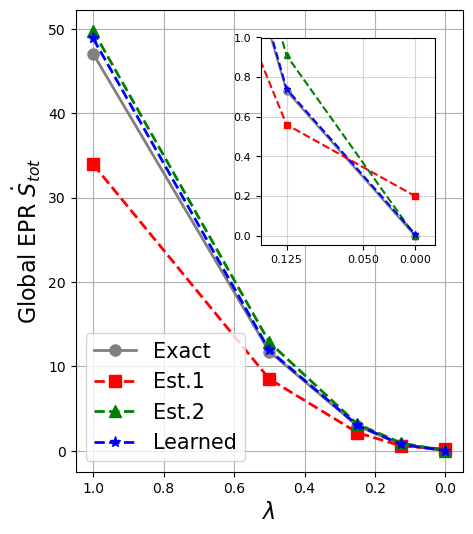

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle

# Data
data = {
    "Exact": [47.06, 11.76, 2.94, 0.73, 0],
    "Est.1": [33.96, 8.51, 2.15, 0.56, 0.20],
    "Est.2": [49.80, 12.86, 3.16, 0.91, 0],
    "Learned": [48.88, 11.91, 3.03, 0.74, 0.0086]
}

colors = {
    "Exact": "gray",
    "Est.1": "red",
    "Est.2": "green",
    "Learned": "blue"
}
markers = {
    "Exact": "o",
    "Est.1": "s",
    "Est.2": "^",
    "Learned": "*"
}

lambda_values = [1, 0.5, 0.25, 0.125, 0]

# Main plot
fig, ax = plt.subplots(figsize=(5, 6))
for label, values in data.items():
    ax.plot(lambda_values, values, marker=markers[label], label=label,linestyle='--' if label != "Exact" else '-',
            color=colors[label], linewidth=2, markersize=8, zorder=4)

ax.set_xlabel(r"$\lambda$", fontsize=16)
ax.set_ylabel(r"Global EPR $\dot{S}_{tot}$", fontsize=16)
ax.legend(fontsize=15, loc='lower left')  # Legend in lower left corner
ax.grid(True)
ax.invert_xaxis()  # Keep main plot axis inverted

# Add inset plot (upper right, x-axis not inverted)
axins = inset_axes(ax, width="45%", height="45%", loc='upper right', borderpad=2)
for label, values in data.items():
    axins.plot(lambda_values, values, marker=markers[label], color=colors[label], linestyle='--' if label != "Exact" else '-',
               linewidth=1.5, markersize=5)

# Inset plot range (x-axis not inverted)
axins.set_xlim(-0.02, 0.15)  # Note order: small to large
axins.set_ylim(-0.05, 1.0)
axins.grid(True, alpha=0.5)
axins.set_xticks([0, 0.05, 0.125])
axins.tick_params(labelsize=8)
axins.invert_xaxis()

plt.savefig("line_chart.svg", bbox_inches='tight', dpi=300)
plt.show()